<a href="https://colab.research.google.com/github/vadlasushma/SpringMvcMongo/blob/master/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# !python -m spacy download en_core_web_lg

In [4]:
!pip install spacy
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.2 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180943 sha256=92352f05c91187ea9c3b49866e26d183c714f6dd568cfa145a538ca71e52b6fc
  Stored in directory: /tmp/pip-ephem-wheel-cache-5ofpri1g/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [5]:
import spacy

In [6]:
import en_core_web_lg
nlp = en_core_web_lg.load()

### Model Building

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
df = pd.read_csv("/content/drive/My Drive/Datasets/SigmaLaw-ABSA.csv")

In [10]:
df.head(10)

,Sentence,Party,Sentiment,Overall Sentiment
0,Petitioner Jae Lee moved to the United States ...,"[[Petitioner Jae Lee,his,he],[]]","[[0,0,0],[]]",0
1,"In the 35 years he has spent in this country, ...","[[he_1,he_2,he_3],[]]","[[0,0,0],[]]",0
2,"In the 35 years he has spent in this country, ...","[[he_1,he_2],[]]","[[0,0],[]]",0
3,In the 35 years he has spent in this country,"[[he],[]]","[[0],[]]",0
4,"In 2008, federal officials received a tip from...","[[lee],[federal officials]]","[[-1],[1]]",-1
5,"In 2008, federal officials received a tip from...","[[],[federal officials]]","[[],[1]]",1
6,Lee had sold the informant ecstasy and marijuana.,"[[lee],[]]","[[-1],[]]",-1
7,"After obtaining a warrant, the officials searc...","[[lee],[officials,they]]","[[-1],[1,1]]",-1
8,the officials searched Lee’s house,"[[lee,],[officials]]","[[0],[0]]",0
9,"they found drugs, cash, and a loaded rifle.","[[],[they]]","[[],[1]]",1


In [11]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git



  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-1gt1tkdy
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-1gt1tkdy
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=11756 sha256=b438503512cdf7ec1858df9c15b75dc52612baf309aabba59b249fda0cda7588
  Stored in directory: /tmp/pip-ephem-wheel-cache-bt4dxfgj/wheels/0d/b3/29/bfe3deffda68980088d17b81331be6667e837ffb4a071bae82
Successfully built preprocess-kgptalkie


In [12]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = ps.cont_exp(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_html_tags(x)
    x = ps.remove_rt(x)
    x = ps.remove_accented_chars(x)
    x = ps.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    x = ps.remove_stopwords(x)
    return x

In [13]:
import preprocess_kgptalkie as ps
import re

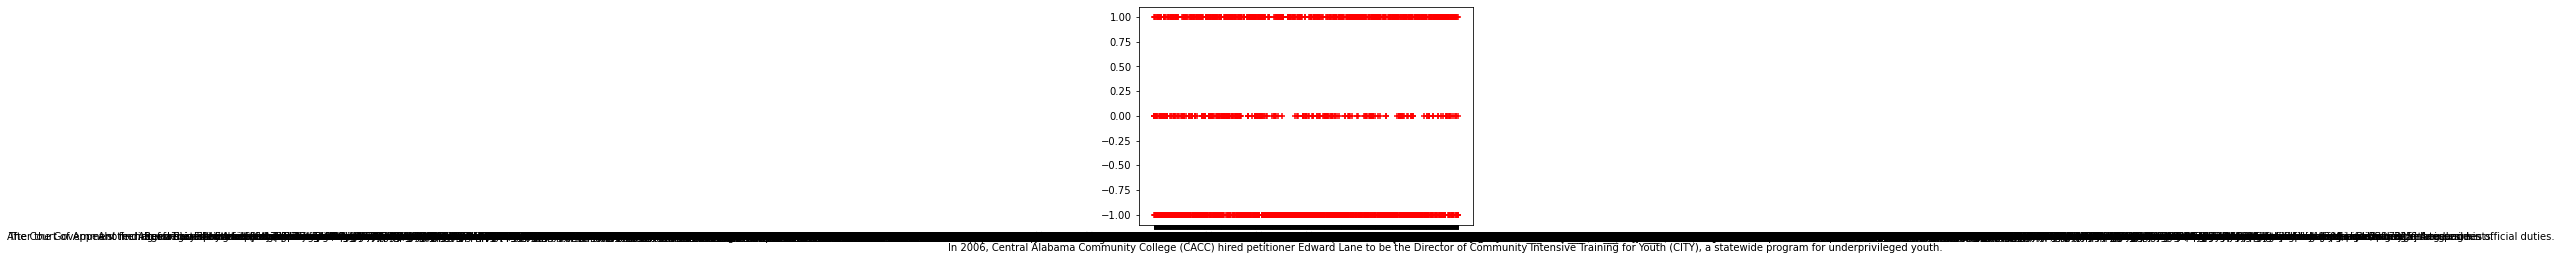

In [16]:
plt.scatter(df['Sentence'],df['Overall Sentiment'],marker='+',color='red')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Class=1, n=380 (19.000%)
Class=0, n=978 (48.900%)
Class=2, n=642 (32.100%)


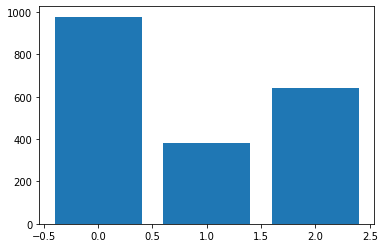

In [17]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder
data = df.values
# split into input and output elements
X, y = data[:, :-3], data[:, -1]
# label encode the target variable
y = LabelEncoder().fit_transform(y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [18]:
df['Sentence'] = df['Sentence'].apply(lambda x: get_clean(x))

In [19]:
df.head(10)

,Sentence,Party,Sentiment,Overall Sentiment
0,petitioner jae lee moved united states south k...,"[[Petitioner Jae Lee,his,he],[]]","[[0,0,0],[]]",0
1,35 years spent country returned south korea s ...,"[[he_1,he_2,he_3],[]]","[[0,0,0],[]]",0
2,35 years spent country returned south korea,"[[he_1,he_2],[]]","[[0,0],[]]",0
3,35 years spent country,"[[he],[]]","[[0],[]]",0
4,2008 federal officials received tip confidenti...,"[[lee],[federal officials]]","[[-1],[1]]",-1
5,2008 federal officials received tip confidenti...,"[[],[federal officials]]","[[],[1]]",1
6,lee sold informant ecstasy marijuana,"[[lee],[]]","[[-1],[]]",-1
7,obtaining warrant officials searched lees hous...,"[[lee],[officials,they]]","[[-1],[1,1]]",-1
8,officials searched lees house,"[[lee,],[officials]]","[[0],[0]]",0
9,found drugs cash loaded rifle,"[[],[they]]","[[],[1]]",1


###`word2vec` Conversion

In [20]:
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [21]:
df['vec'] = df['Sentence'].apply(lambda x: get_vec(x))

In [22]:
df.head(10)

,Sentence,Party,Sentiment,Overall Sentiment,vec
0,petitioner jae lee moved united states south k...,"[[Petitioner Jae Lee,his,he],[]]","[[0,0,0],[]]",0,"[0.030777875, 0.2021203, 0.0701223, -0.0953348..."
1,35 years spent country returned south korea s ...,"[[he_1,he_2,he_3],[]]","[[0,0,0],[]]",0,"[0.08635894, 0.09417876, 0.03184888, -0.080914..."
2,35 years spent country returned south korea,"[[he_1,he_2],[]]","[[0,0],[]]",0,"[0.20109887, 0.31250125, 0.30185446, -0.128174..."
3,35 years spent country,"[[he],[]]","[[0],[]]",0,"[0.13878301, 0.44638747, 0.3252725, -0.2856100..."
4,2008 federal officials received tip confidenti...,"[[lee],[federal officials]]","[[-1],[1]]",-1,"[-0.15542126, 0.10496125, 0.10098923, 0.082842..."
5,2008 federal officials received tip confidenti...,"[[],[federal officials]]","[[],[1]]",1,"[-0.23235014, -0.0055835736, 0.1317167, 0.1762..."
6,lee sold informant ecstasy marijuana,"[[lee],[]]","[[-1],[]]",-1,"[-0.04772079, 0.259724, 0.057970803, -0.047896..."
7,obtaining warrant officials searched lees hous...,"[[lee],[officials,they]]","[[-1],[1,1]]",-1,"[-0.14927511, 0.059969686, -0.046466183, -0.09..."
8,officials searched lees house,"[[lee,],[officials]]","[[0],[0]]",0,"[-0.075735, -0.044145003, 0.14323275, -0.25149..."
9,found drugs cash loaded rifle,"[[],[they]]","[[],[1]]",1,"[-0.10108123, 0.16372731, -0.1315458, -0.02429..."


In [23]:
# what do you do when your model is being trained???

In [24]:
X = df['vec'].to_numpy()
X = X.reshape(-1, 1)

In [25]:
X.shape

(2000, 1)

In [26]:
X = np.concatenate(np.concatenate(X, axis = 0), axis = 0).reshape(-1, 300)

In [27]:
X.shape

(2000, 300)

In [28]:
y = df['Overall Sentiment']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 109, stratify = y)

In [30]:
X_train.shape, X_test.shape

((1600, 300), (400, 300))

### Train ML Model

In [31]:
logclf = LogisticRegression(solver='liblinear')

In [32]:
logclf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
y_pred = logclf.predict(X_test)

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.62      0.77      0.69       196
           0       0.68      0.37      0.48        76
           1       0.45      0.41      0.43       128

    accuracy                           0.58       400
   macro avg       0.58      0.52      0.53       400
weighted avg       0.58      0.58      0.57       400



In [62]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# evaluate model
scores = cross_val_score(logclf, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.605 (0.036)


In [35]:
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[150,   4,  42],
       [ 24,  28,  24],
       [ 66,   9,  53]])

Text(0.5, 257.44, 'Predicted label')

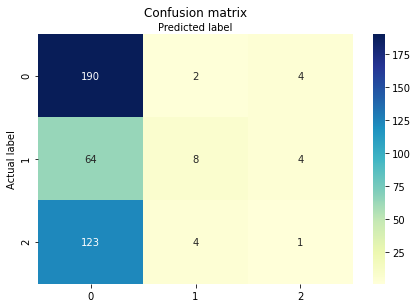

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
class_names=[0,1,-1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [36]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


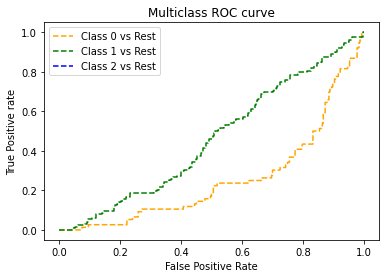

In [37]:

pred = logclf.predict(X_test)
pred_prob = logclf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);    

In [38]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

In [39]:
dtclf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
dtclf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = dtclf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.50      0.97      0.66       196
           0       0.57      0.11      0.18        76
           1       0.11      0.01      0.01       128

    accuracy                           0.50       400
   macro avg       0.40      0.36      0.29       400
weighted avg       0.39      0.50      0.36       400



In [63]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# evaluate model
scores = cross_val_score(dtclf, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.494 (0.023)


Text(0.5, 257.44, 'Predicted label')

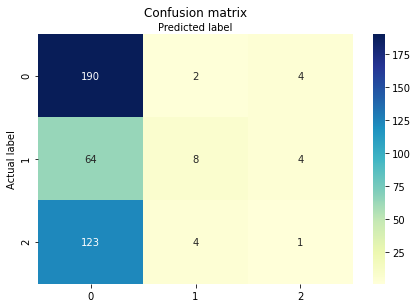

In [42]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
class_names=[0,1,-1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


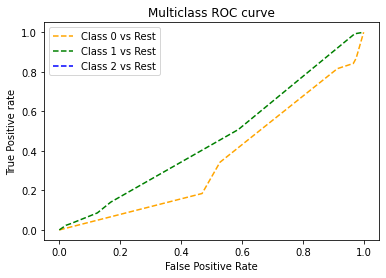

In [43]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
pred = dtclf.predict(X_test)
pred_prob = dtclf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);    

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
rfclf=RandomForestClassifier(n_estimators=100)

rfclf.fit(X_train,y_train)

y_pred = rfclf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.61      0.85      0.71       196
           0       0.83      0.46      0.59        76
           1       0.55      0.36      0.43       128

    accuracy                           0.62       400
   macro avg       0.66      0.56      0.58       400
weighted avg       0.63      0.62      0.60       400



In [64]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# evaluate model
scores = cross_val_score(rfclf, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.632 (0.025)


Text(0.5, 257.44, 'Predicted label')

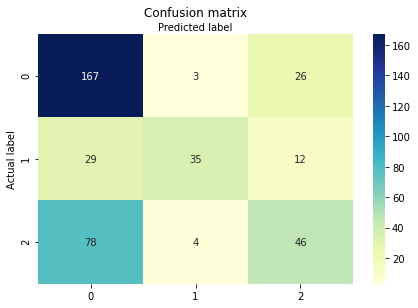

In [46]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
class_names=[0,1,-1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


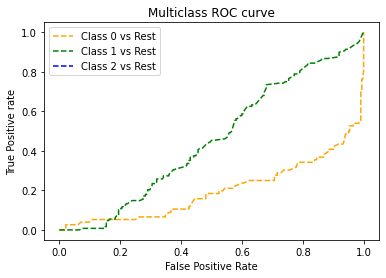

In [47]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
pred = rfclf.predict(X_test)
pred_prob = rfclf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);    

In [48]:
from sklearn import svm

#Create a svm Classifier
svmclf = svm.SVC(kernel='linear',probability= True) # Linear Kernel

#Train the model using the training sets
svmclf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = svmclf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.62      0.80      0.70       196
           0       0.69      0.41      0.51        76
           1       0.48      0.39      0.43       128

    accuracy                           0.59       400
   macro avg       0.60      0.53      0.55       400
weighted avg       0.59      0.59      0.58       400



In [65]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# evaluate model
scores = cross_val_score(svmclf, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.604 (0.031)


Text(0.5, 257.44, 'Predicted label')

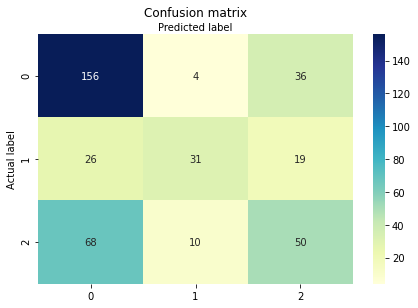

In [49]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
class_names=[0,1,-1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


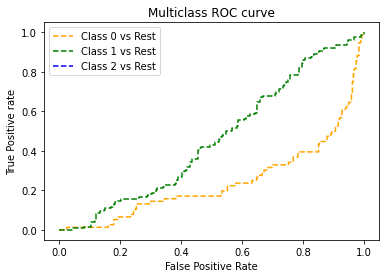

In [50]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
pred = svmclf.predict(X_test)
pred_prob = svmclf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);   

In [51]:
from sklearn.neighbors import KNeighborsClassifier

In [52]:
knn = KNeighborsClassifier(n_neighbors=7)
 
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.58      0.85      0.69       196
           0       0.81      0.28      0.41        76
           1       0.51      0.34      0.41       128

    accuracy                           0.58       400
   macro avg       0.63      0.49      0.50       400
weighted avg       0.60      0.58      0.54       400



In [66]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# evaluate model
scores = cross_val_score(knn, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.566 (0.034)


Text(0.5, 257.44, 'Predicted label')

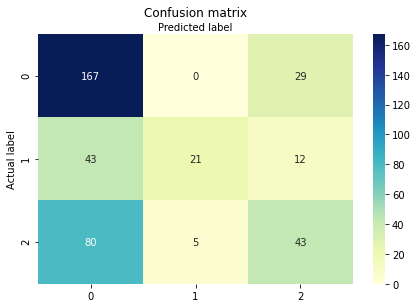

In [53]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
class_names=[0,1,-1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


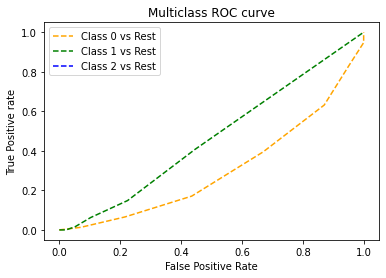

In [54]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
pred = knn.predict(X_test)
pred_prob = knn.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);   

In [55]:
from xgboost import XGBClassifier

In [56]:
xgbmodel = XGBClassifier()
xgbmodel.fit(X_train, y_train)
# make predictions for test data
y_pred = xgbmodel.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.60      0.80      0.69       196
           0       0.73      0.47      0.58        76
           1       0.46      0.33      0.38       128

    accuracy                           0.58       400
   macro avg       0.60      0.53      0.55       400
weighted avg       0.58      0.58      0.57       400



In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# evaluate model
scores = cross_val_score(xgbmodel, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Text(0.5, 257.44, 'Predicted label')

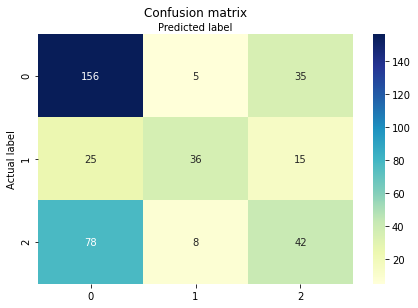

In [57]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
class_names=[0,1,-1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


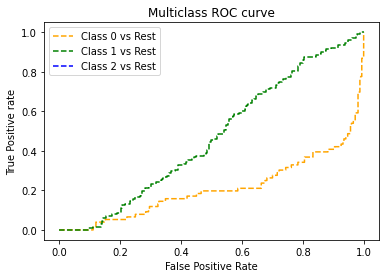

In [58]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
pred = xgbmodel.predict(X_test)
pred_prob = xgbmodel.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);   